In [1]:
import pandas as pd
import json
import re

# 4chan -> Low level moderation (moderation varies from board to board but in escence all illegal related content is removed), aside from ilegal content, the board is also moderated for spam and other types of abuse. The majority of speech aside from that is allowed.

## Cleaning text and performing a base level analysis

In [2]:
# lets transform the data into a pandas dataframe, currently it is stored in a dictionary of k=str, v=list[str]
# we will use the json module to load the data from the json file
with open('../Data/data_chan.json', 'r') as f:
    data = json.load(f)

# Create a pandas dataframe with 2 title and comment columns
df = pd.DataFrame(columns=['title', 'comment'])

# Iterate through the dictionary and append the data to the dataframe
for title, comments in data.items():
    for comment in comments:
        df = df.append({'title': title, 'comment': comment}, ignore_index=True)

In [3]:
df.head()

,title,comment
0,All the cool kids are doing it.,&gt;&gt;400714173&gt;no pepe what are you doin...
1,All the cool kids are doing it.,&gt;&gt;400708757https://www.youtube.com/watch...
2,All the cool kids are doing it.,&gt;&gt;400713918&gt;if you don&#039;t like th...
3,All the cool kids are doing it.,&gt;&gt;400708823And I wonder how many big ole...
4,All the cool kids are doing it.,&gt;&gt;400714594Vatniggers get into the meat ...


In [4]:
# lets make some preeliminary analysis on the data with spacy
import spacy
nlp = spacy.load('en_core_web_md')

In [5]:
# clean the text from 'title' and 'comment' columns
def clean_text(text):
    # make everything lowercase
    text = text.lower()
    # only lowercase letters no numbers or special characters
    text = re.sub(r'[^a-z]', ' ', text)
    # Remove any website links
    text = re.sub(r'http\S+', '', text)
    # only accept nouns, pronouns and entities
    doc = nlp(text)
    text = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN', 'PRON', 'ADJ'] and len(token.text) > 3 and 'quot' not in token.text]
    return text

In [6]:
# apply the clean_text function to the dataframe
# df['title'] = df['title'].apply(clean_text)
df['comment'] = df['comment'].apply(clean_text)

In [ ]:
# remove comments with less than 3 words
df = df[df['comment'].apply(lambda x: len(x) > 3)]

In [7]:
df.head()

,title,comment
0,All the cool kids are doing it.,"[pepe, what, body]"
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]"
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian..."
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ..."
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]"


In [8]:
# lets create a new column with the length of the comment
df['length'] = df['comment'].apply(lambda x: len(x))

## Sentiment and Subjectivity Analysis

In [9]:
# lets analyze the sentiment of the comments
from spacytextblob.spacytextblob import SpacyTextBlob
nlp.add_pipe('spacytextblob')

In [10]:
# lets create a new column with the sentiment of the comment
df['sentiment'] = df['comment'].apply(lambda x: nlp(' '.join(x))._.blob.polarity)

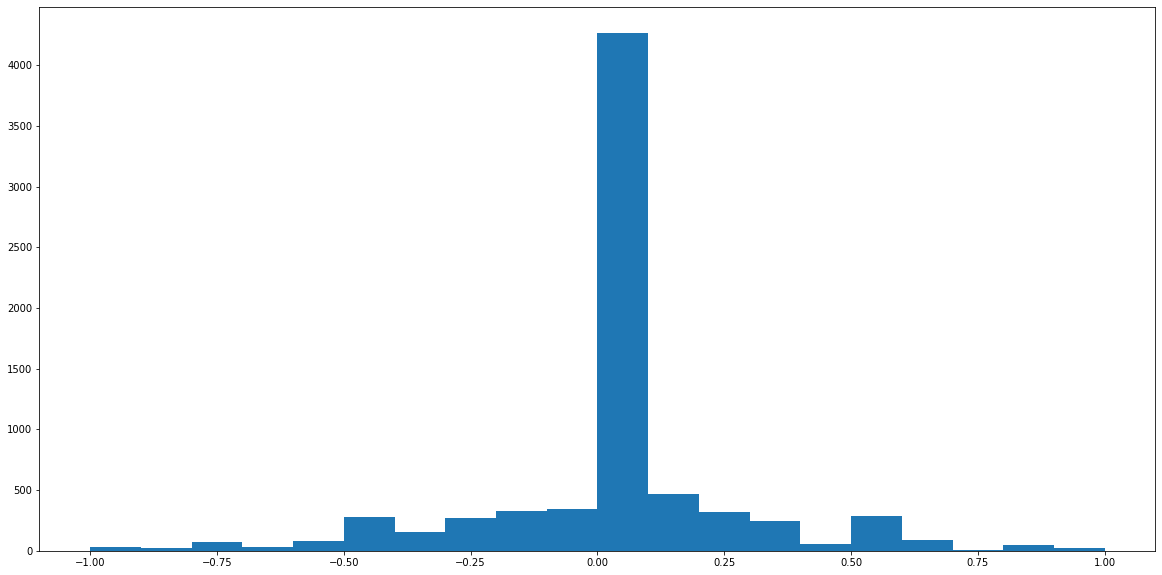

In [11]:
# lets plot the sentiment of the comments
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.hist(df['sentiment'], bins=20)
plt.show()

In [12]:
# show 5 samples of negative comments, in which sentiment is less than -0.5
df[df['sentiment'] < -0.5].sample(5)

,title,comment,length,sentiment
4551,&gt;Putin the genocidal war criminal bet on a ...,"[memeflag, retard, smartest, person, roomevery...",6,-0.9
6610,&gt;&quot;Russia is an Orthodox country profes...,"[people, evil]",2,-1.0
4237,&gt;Le brain isn’t fully developed until 25Is ...,"[this, girls, that, bodies, women, them, rape,...",12,-0.6
2504,PRESIDENT DONALD J TRUMP @POTUS45https://www.d...,"[akari, destroyedcheck, fucking, askuka, frens...",7,-0.7
2420,Kanye is Based AF and confirmed a Pol/Ack. He ...,[pathetic],1,-1.0


In [13]:
# show 5 samples of positive comments, in which sentiment is greater than 0.5
df[df['sentiment'] > 0.5].sample(5)

,title,comment,length,sentiment
2114,There are two days left for the commotion to b...,"[good, anon, thought, temptation, devil, himself]",6,0.7
2540,Any tips how to beat the inflation?,"[grocery, stores, perimeter, essentials, isles...",10,0.8
6264,Even if the government arrested and executed e...,"[eggy, good, incel]",3,0.7
6491,Why were so many top ranking Nazis gay?,"[ideal, society]",2,0.9
1920,What happened to the basic bitch type of girl?...,"[great, replacement]",2,0.8


In [14]:
# lets create a new column with the subjectivity of the comment
df['subjectivity'] = df['comment'].apply(lambda x: nlp(' '.join(x))._.blob.subjectivity)

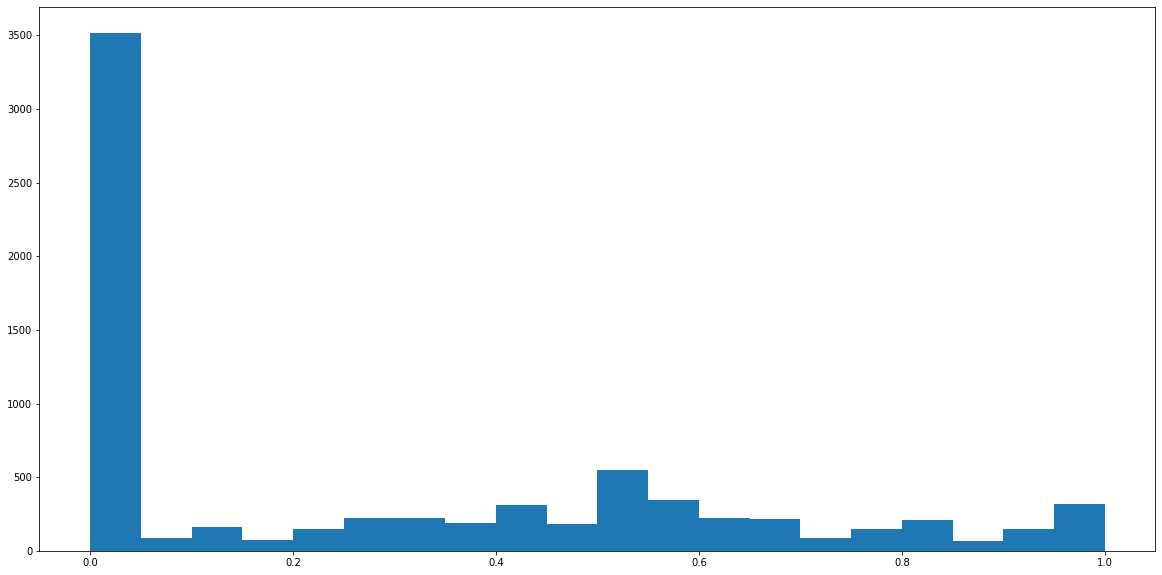

In [15]:
# lets plot the subjectivity of the comments
plt.figure(figsize=(20, 10))
plt.hist(df['subjectivity'], bins=20)
plt.show()

In [16]:
# show 5 samples of subjective comments, in which subjectivity is greater than 0.5
df[df['subjectivity'] > 0.5].sample(5)

,title,comment,length,sentiment,subjectivity
5132,/pol humour thread,"[this, smart, apartment, groceries, hours]",5,0.214286,0.642857
6194,fuck links,"[sack, shit]",2,-0.200000,0.800000
6657,"The absolute state of American youth, they use...","[there, expensive, kitchenaid, robot, backgrou...",18,-0.025000,0.625000
3270,"If Elon didn&#039;t own Twitter, the story abo...","[lack, censorship, cool]",3,0.350000,0.650000
1865,White woman redemption arc?,"[fuck, anyone, stupid, husky, wolf, danger, ge...",9,-0.383333,0.700000


In [17]:
# show 5 samples of objective comments, in which subjectivity is less than 0.5
df[df['subjectivity'] < 0.5].sample(5)

,title,comment,length,sentiment,subjectivity
7310,Why do you guys hate me because of my nation? ...,"[nobody, government]",2,0.0,0.0
4096,Why is this tipping bullshit starting to creep...,[],0,0.0,0.0
3587,Former Head of MI6https://www.youtube.com/watc...,"[former, chief, ukraine]",3,0.0,0.0
4895,I made a post yesterday telling you that I was...,[sage],1,0.0,0.0
3162,Nick Fuentes and Richard Spencer link up and h...,"[amouranth, neekolul]",2,0.0,0.0


62001


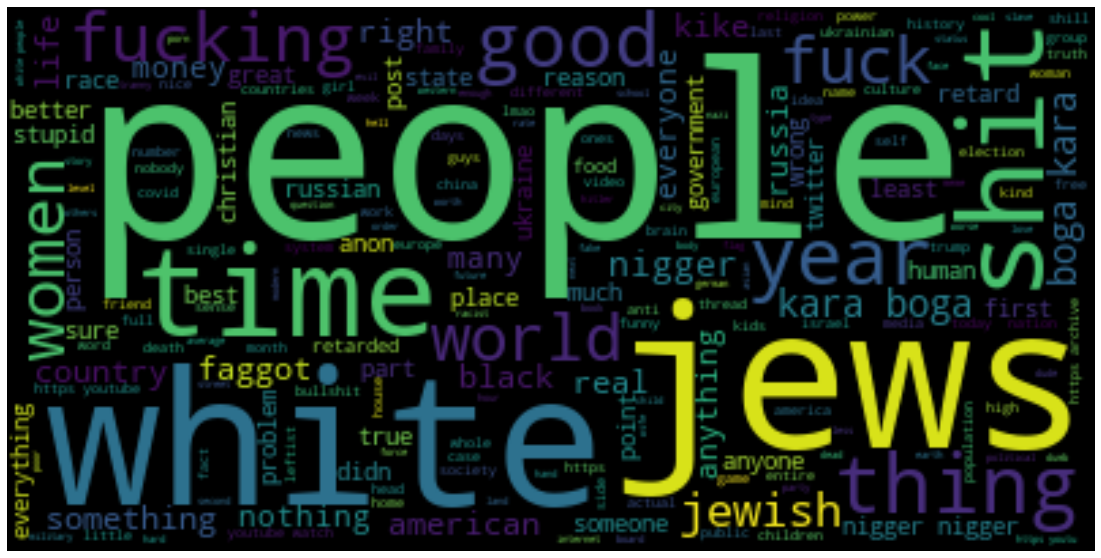

In [18]:
# lets create a word cloud of the most common words in the comments
from wordcloud import WordCloud

# create a string of all the comments
all_comments = list()
for comment in df['comment']:
    all_comments.extend(comment)

print(len(all_comments)) # the number of unique words in the comments

# create a word cloud object
wordcloud = WordCloud().generate(' '.join(all_comments))

# plot the word cloud, make it larger
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

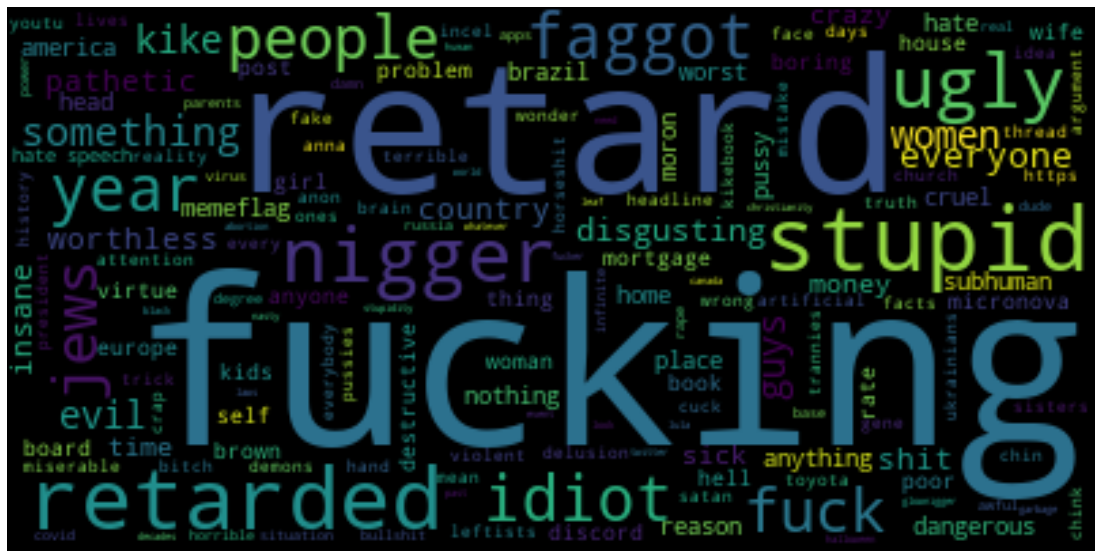

In [19]:
# lets create a word cloud of the most common words in the comments, but only for negative comments
negative_comments = ' '.join(df[df['sentiment'] < -0.5]['comment'].apply(lambda x: ' '.join(x)))

# create a word cloud object
wordcloud = WordCloud().generate(negative_comments)

plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# check how many unique words are in the comments
total_unique = len(all_comments)

total_words = 0
for comment in df['comment']:
    total_words += len(comment)

# average unique words per comment
unique_words_by_comment = total_unique / total_words
unique_words_by_comment

1.0

In [21]:
total_words

62001

In [22]:
# check how many average words are in the comments
average_words_by_comment = sum(df['length']) / len(df)
average_words_by_comment

8.339071956960323

## Hate Analysis in 4chan: A Case Study
### We scraped data from -> https://en.wikipedia.org/wiki/List_of_ethnic_slurs to generate a hate term corpus which then we used to calculate hate scores for each post in 4chan. Then we calculated the hate score for each thread and plotted the results.

In [23]:
# load the 2 other data frames to check on hate speech
df_hate = pd.read_csv('../../GeneralData/ethnic_slurs.csv')
df_hate.head(20)

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...
5,afro engineering african engineering or nigger...,united states,black american people,shoddy secondrate or unconventional makeshift ...
6,ah chah,hong kong,south asian people,from cantonese yale ach from acch meaning good...
7,ali baba,united states,iraqi people,an iraqi suspected of criminal activity
8,alligator bait gator bait,united states more commonly used in states whe...,black people especially black children,first used in the early 20th century although ...
9,alpine serb,serbocroatian alpski srbin exyugoslavia,people of slovenian origin,


In [24]:
# r strip Location column
df_hate['Location'] = df_hate['Location'].apply(lambda x: x.rstrip())
df_hate.head(20)

,Term,Location,Target,Meaning
0,abbie abe abie,north america,jewish men,originated before the 1950s from the proper na...
1,abc,east asia,americanborn chinese han or other chinese incl...,the term implies an otherness or lack of conne...
2,abcd,south asians in the us,americanborn confused desi indian americans or...,used chiefly by south asian immigrants to impl...
3,abidabeed plural,middle east and north africa,black african people,arabic for slave associated with the arab slav...
4,aboabbo,australia,australian aboriginal person,originally this was simply an informal term fo...
5,afro engineering african engineering or nigger...,united states,black american people,shoddy secondrate or unconventional makeshift ...
6,ah chah,hong kong,south asian people,from cantonese yale ach from acch meaning good...
7,ali baba,united states,iraqi people,an iraqi suspected of criminal activity
8,alligator bait gator bait,united states more commonly used in states whe...,black people especially black children,first used in the early 20th century although ...
9,alpine serb,serbocroatian alpski srbin exyugoslavia,people of slovenian origin,


In [25]:
# make a set of all unique words in Term 
hate_terms = set()
for term in df_hate['Term']:
    for word in term.split():
        if len(word) < 4:
            continue
        hate_terms.add(word)

In [26]:
# check if the comments contain any of the hate words
hate_score = []
for comment in df['comment']:
    hate_count = 0
    for content in comment:
        for word in hate_terms:
            if word in content:
                hate_count += 1

    hate_score.append(hate_count)

# add the hate score to the dataframe
df['hate_score'] = hate_score
df.head()
                

,title,comment,length,sentiment,subjectivity,hate_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.00,0.00,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.00,0.00,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.20,0.30,1
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.15,0.65,0
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.00,0.00,1


In [27]:
df.head(20)

,title,comment,length,sentiment,subjectivity,hate_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.000000,0.000000,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.000000,0.000000,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.200000,0.300000,1
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.150000,0.650000,0
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.000000,0.000000,1
5,&gt;Two 16-year-old twins escaped from their a...,"[something, some]",2,0.000000,0.000000,0
6,&gt;Two 16-year-old twins escaped from their a...,[test],1,0.000000,0.000000,0
7,&gt;Two 16-year-old twins escaped from their a...,"[they, black, nobody, this]",4,-0.166667,0.433333,1
8,&gt;Two 16-year-old twins escaped from their a...,"[true, bolivian]",2,0.350000,0.650000,0
9,&gt;Two 16-year-old twins escaped from their a...,"[bitch, your, good, women, physical, mental, h...",7,0.200000,0.314286,0


In [28]:
# get the top 5 rows with the highest hate score
df.sort_values(by='hate_score', ascending=False).head(5)

,title,comment,length,sentiment,subjectivity,hate_score
4981,He is mostly known for not being Michael Jorda...,"[nigger, nigger, nigger, nigger, nigger, nigge...",113,0.000000,0.000000,113
5092,your corrupt right wing politicians are crumbl...,"[this, spam, thread, faggot, niggers, obvious,...",88,0.000000,0.500000,22
3768,What do I put on it /pol/?,"[nigger, niggerniggerniggernigger, niggernigge...",16,0.000000,0.000000,16
7050,All non-Whites are the result of Cro-Magnon (W...,"[theory, they, africans, wrong, https, release...",126,-0.027083,0.191667,15
3119,Even Reddit of all places is not buying it any...,"[they, they, disproportional, amount, whites, ...",98,0.010667,0.342667,14


In [29]:
# Get the percentage of hate score devided by the total length of the comment
df['hate_score_percentage'] = df['hate_score'] / df['length'] * 100
df.head()

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.00,0.00,0,0.000000
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.00,0.00,0,0.000000
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.20,0.30,1,12.500000
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.15,0.65,0,0.000000
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.00,0.00,1,33.333333


### Percentage of Hate Score out of total comments -> 6.02%

In [30]:
# get the sum of the total hate score / sum of the total length of the comment * 100
percentage_total_hate = df['hate_score'].sum() / df['length'].sum() * 100
f"{percentage_total_hate:.2f}%"

'6.14%'

In [31]:
# get the top 5 rows with the highest hate score percentage, where length > 5
df[df['length'] > 5].sort_values(by='hate_score_percentage', ascending=False).head(7)

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage
3768,What do I put on it /pol/?,"[nigger, niggerniggerniggernigger, niggernigge...",16,0.000000,0.000000,16,100.000000
4981,He is mostly known for not being Michael Jorda...,"[nigger, nigger, nigger, nigger, nigger, nigge...",113,0.000000,0.000000,113,100.000000
1940,Intredasting we are not having BBC treads righ...,"[white, male, japanese, korean, female, thread]",6,0.000000,0.066667,5,83.333333
156,Some people say that after a spree killer shoo...,"[today, stupid, nigger, suspicion, nigger, sure]",6,-0.150000,0.944444,3,50.000000
598,What are the political implications of closet ...,"[goypublicans, biden, they, black, female, pre...",6,-0.083333,0.300000,3,50.000000
7145,Come and watch niggers beg to be freed from pr...,"[white, prison, resources, niggers, help, years]",6,0.000000,0.000000,3,50.000000
6216,the most powerful groups of people in history ...,"[celts, germans, niggers, shitskinsfuck, disgu...",6,-0.593750,0.750000,3,50.000000


### Analysing offensive speech

In [36]:
# load csv as list
import csv
with open('../../GeneralData/offensive_words.csv', 'r') as f:
    reader = csv.reader(f)
    offensive_words = list(reader)[1:]

offensive_words = [word[0] for word in offensive_words]
offensive_words

['arse',
 'arsehead',
 'arsehole',
 'ass',
 'asshole',
 'bastard',
 'bithc',
 'bloody',
 'blood',
 'bollocks',
 'brotherfucker',
 'bugger',
 'bullshit',
 'childfucker',
 'cock',
 'cocksucker',
 'crap',
 'cunt',
 'damn',
 'dick',
 'dickhead',
 'dyke',
 'fatherfucker',
 'frigger',
 'fuck',
 'goddamn',
 'godsdamn',
 'hell',
 'holy shit',
 'horseshit',
 'jesus fuck',
 'kike',
 'motherfucker',
 'nigga',
 'nigra',
 'nigger',
 'piss',
 'prick',
 'pussy',
 'shit',
 'shit ass',
 'shite',
 'sisterfucker',
 'slut',
 'son of a bithc',
 'son of a whore',
 'spastic',
 'twat',
 'wanker']

In [37]:
# check if the comments contain any of the offensive words
offensive_score = []
for comment in df['comment']:
    offensive_count = 0
    for content in comment:
        for word in offensive_words:
            if word in content:
                offensive_count += 1

    offensive_score.append(offensive_count)

# add the offensive score to the dataframe
df['offensive_score'] = offensive_score
df.head(10)

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage,offensive_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.000000,0.000000,0,0.000000,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.000000,0.000000,0,0.000000,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.200000,0.300000,1,12.500000,0
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.150000,0.650000,0,0.000000,1
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.000000,0.000000,1,33.333333,1
5,&gt;Two 16-year-old twins escaped from their a...,"[something, some]",2,0.000000,0.000000,0,0.000000,0
6,&gt;Two 16-year-old twins escaped from their a...,[test],1,0.000000,0.000000,0,0.000000,0
7,&gt;Two 16-year-old twins escaped from their a...,"[they, black, nobody, this]",4,-0.166667,0.433333,1,25.000000,0
8,&gt;Two 16-year-old twins escaped from their a...,"[true, bolivian]",2,0.350000,0.650000,0,0.000000,0
9,&gt;Two 16-year-old twins escaped from their a...,"[bitch, your, good, women, physical, mental, h...",7,0.200000,0.314286,0,0.000000,0


In [39]:
# get the top 5 rows with the highest offensive score
df.sort_values(by='offensive_score', ascending=False).head(10)

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage,offensive_score
4981,He is mostly known for not being Michael Jorda...,"[nigger, nigger, nigger, nigger, nigger, nigge...",113,0.000000,0.000000,113,100.000000,113
5092,your corrupt right wing politicians are crumbl...,"[this, spam, thread, faggot, niggers, obvious,...",88,0.000000,0.500000,22,25.000000,22
3768,What do I put on it /pol/?,"[nigger, niggerniggerniggernigger, niggernigge...",16,0.000000,0.000000,16,100.000000,16
2364,Previous: &gt;&gt;402026522Timeline /tug/: htt...,[hahahahahahahahahaaahjahahhhhhhhhhhhhhhahahah...,75,0.008036,0.619643,0,0.000000,12
749,Let&#039;s have a discussion about literal ver...,"[slaves, butthurt, rebellion, higher, dimensio...",98,0.036458,0.526389,9,9.183673,10
4706,My top 3 most redpilled songs:Saint PabloNew S...,"[that, pussy, niggas, pussy, contracts, meyou,...",26,0.000000,0.000000,0,0.000000,10
973,"Why do you hate me, anon?","[holy, shit, mindsi, stupid, kike, fuckface, l...",42,-0.301667,0.591667,4,9.523810,9
19,This is what happens when you pay them $15 an ...,"[companies, shit, mass, offs, shit, benefits, ...",28,0.008333,0.750000,2,7.142857,8
5215,Kikes banned Ye from Instagram for 30 days,"[heyhey, fucking, linkyou, fucking, niggerfuck...",9,-0.550000,0.750000,2,22.222222,8
3898,China will launch and connect the finale modul...,"[that, cool, china, shit, nasa, blueprint, pap...",52,-0.089375,0.709444,2,3.846154,7


In [40]:
percentage_total_offensive = df['offensive_score'].sum() / df['length'].sum() * 100
f"{percentage_total_offensive:.2f}%"

'3.76%'

### Violence Analysis

In [41]:
# Read Csv as list
with open('../../GeneralData/violent_words.csv', 'r') as f:
    reader = csv.reader(f)
    violent_words = list(reader)[1:]

violent_words = [word[0] for word in violent_words]
violent_words

['acid',
 'aggressor',
 'agitator',
 'aim',
 'alert',
 'ambush',
 'ammunition',
 'anarchy',
 'anguish',
 'annihilate',
 'apartheid',
 'arms',
 'arsenal',
 'artillery',
 'assassin',
 'assassinate',
 'assault',
 'atrocity',
 'attack',
 'authority',
 'automatic',
 'faction',
 'fanatic',
 'fatal',
 'fear',
 'fearful',
 'felon',
 'ferment',
 'ferocious',
 'feud',
 'fierce',
 'fiery',
 'fight',
 'fighter',
 'force',
 'forceful',
 'forces',
 'fray',
 'frenzy',
 'front',
 'lines',
 'fuel',
 'fugitive',
 'furtive',
 'cadaver',
 'camouflage',
 'campaign',
 'captive',
 'capture',
 'careen',
 'carnage',
 'casualties',
 'cataclysm',
 'causes',
 'chaos',
 'charge',
 'charred',
 'checking',
 'clandestine',
 'clash',
 'coalition',
 'collapse',
 'combat',
 'commandos',
 'concentration',
 'concussion',
 'conflagration',
 'conflict',
 'confrontation',
 'conquer',
 'consequences',
 'consolidate',
 'conspiracy',
 'conspire',
 'control',
 'coordinates',
 'corpse',
 'counterattack',
 'countermand',
 'crash',

In [42]:
# check if the comments contain any of the violent words
violent_score = []
for comment in df['comment']:
    violent_count = 0
    for content in comment:
        for word in violent_words:
            if word in content:
                violent_count += 1

    violent_score.append(violent_count)

# add the violent score to the dataframe
df['violent_score'] = violent_score
df.head(10)

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage,offensive_score,violent_score
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.000000,0.000000,0,0.000000,0,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.000000,0.000000,0,0.000000,0,0
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.200000,0.300000,1,12.500000,0,2
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.150000,0.650000,0,0.000000,1,1
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.000000,0.000000,1,33.333333,1,0
5,&gt;Two 16-year-old twins escaped from their a...,"[something, some]",2,0.000000,0.000000,0,0.000000,0,0
6,&gt;Two 16-year-old twins escaped from their a...,[test],1,0.000000,0.000000,0,0.000000,0,0
7,&gt;Two 16-year-old twins escaped from their a...,"[they, black, nobody, this]",4,-0.166667,0.433333,1,25.000000,0,0
8,&gt;Two 16-year-old twins escaped from their a...,"[true, bolivian]",2,0.350000,0.650000,0,0.000000,0,0
9,&gt;Two 16-year-old twins escaped from their a...,"[bitch, your, good, women, physical, mental, h...",7,0.200000,0.314286,0,0.000000,0,0


## Lets do some natural clustering analysis, let's see how many natural clusters we can find in the data

In [43]:
# Perform a natural clustering on the comments
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# create a list of all the comments
all_comments = list()
for comment in df['comment']:
    all_comments.append(' '.join(comment))

# create a tfidf vectorizer object
vectorizer = TfidfVectorizer(stop_words='english')

# fit the vectorizer to the comments
X = vectorizer.fit_transform(all_comments)

# create a kmeans object
kmeans = KMeans(n_clusters=5, random_state=0)

# fit the kmeans object to the vectorizer
kmeans.fit(X)

# get the cluster labels
labels = kmeans.labels_

# add the cluster labels to the dataframe
df['cluster'] = labels
df.head(10)

,title,comment,length,sentiment,subjectivity,hate_score,hate_score_percentage,offensive_score,violent_score,cluster
0,All the cool kids are doing it.,"[pepe, what, body]",3,0.000000,0.000000,0,0.000000,0,0,0
1,All the cool kids are doing it.,"[https, youtube, watch, svsoh]",4,0.000000,0.000000,0,0.000000,0,0,4
2,All the cool kids are doing it.,"[richard, spencer, tier, opposition, ukrainian...",8,0.200000,0.300000,1,12.500000,0,2,0
3,All the cool kids are doing it.,"[many, brains, titanic, imagery, their, meme, ...",9,0.150000,0.650000,0,0.000000,1,1,3
4,All the cool kids are doing it.,"[vatniggers, meat, grinder]",3,0.000000,0.000000,1,33.333333,1,0,0
5,&gt;Two 16-year-old twins escaped from their a...,"[something, some]",2,0.000000,0.000000,0,0.000000,0,0,0
6,&gt;Two 16-year-old twins escaped from their a...,[test],1,0.000000,0.000000,0,0.000000,0,0,0
7,&gt;Two 16-year-old twins escaped from their a...,"[they, black, nobody, this]",4,-0.166667,0.433333,1,25.000000,0,0,0
8,&gt;Two 16-year-old twins escaped from their a...,"[true, bolivian]",2,0.350000,0.650000,0,0.000000,0,0,0
9,&gt;Two 16-year-old twins escaped from their a...,"[bitch, your, good, women, physical, mental, h...",7,0.200000,0.314286,0,0.000000,0,0,0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


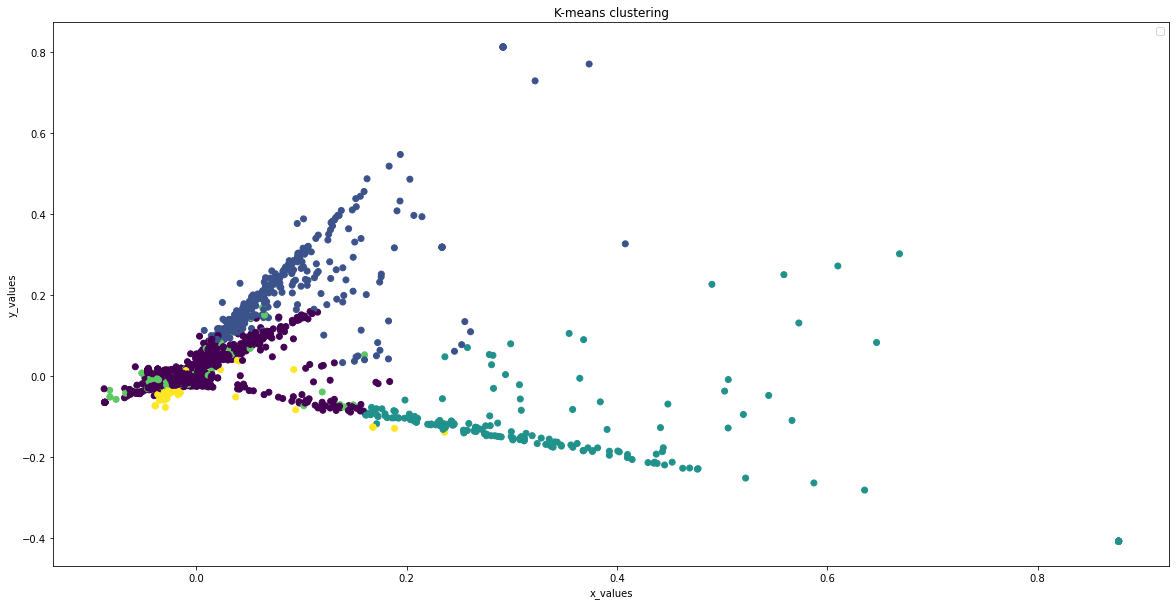

In [47]:
# Plot the clusters
from sklearn.decomposition import PCA

# create a pca object
pca = PCA(n_components=2)

# fit the pca object to the vectorizer
pca.fit(X.toarray())

# get the first two principal components
data2D = pca.transform(X.toarray())

# plot the clusters
plt.figure(figsize=(20,10))
plt.scatter(data2D[:,0], data2D[:,1], c=labels)
# Add legend, title and axis names
plt.legend()
plt.title('K-means clustering')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.show()

In [53]:
# Check the top 10 words in each cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print('\n')

Cluster 0:
 good
 nigger
 time
 women
 fuck
 faggot
 white
 niggers
 country
 years


Cluster 1:
 people
 white
 black
 things
 world
 food
 time
 good
 shit
 thing


Cluster 2:
 jews
 white
 people
 jewish
 kanye
 shit
 blacks
 whites
 jesus
 right


Cluster 3:
 shit
 fucking
 kike
 anon
 fuck
 holy
 faggot
 time
 nigger
 years


Cluster 4:
 https
 watch
 youtube
 youtu
 archive
 status
 twitter
 video
 plebs
 redpills




c:\Users\nicol\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [54]:
# Get 5 random comments from each cluster
for i in range(5):
    print("Cluster %d:" % i)
    for comment in df[df['cluster'] == i]['comment'].sample(5):
        print(' '.join(comment))
    print('\n')

Cluster 0:
wrong greatest political misconceptions today conservatives individualist libertarians liberals collectivists other their great value this
jabbies they nobody reponsibility duress they their
movie

trump your lord savior


Cluster 1:
heat people sightings english south americans ones ufos
people pods they they their bloated obscene corpses crane their pods deep
public awareness people medical license there less quacks artists
people they suicide sorry truth yourself lucky english minds some worst ways possible this face delusional
everything they them this goyslop meme perfect example same people access cheap energy cheap food energy anons funny other people narratives their food


Cluster 2:
what edomites history herod edomites judea jesus edomite jews they israelites them slaves herod edomites esau amalekites jews edomites israelites land khazariaso jews today star remphan satanist bible chosenwere their they esau race mixerwhich covenant other pure descendants adam whites